## First step to clean the dataset:

- Select only English movies
- Select onlu full-length feature (movies of more than one hour long)
- Remove movies for which we don't have the title

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import requests
import numpy as np
import string
import json

In [3]:
character_metadata = pd.read_csv('Data/character.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_release_date',
                                                                              'Character_name',
                                                                              'Actor_date_of_birth',
                                                                              'Actor_gender',
                                                                              'Actor_height',
                                                                              'Actor_ethnicity',
                                                                              'Actor_name',
                                                                              'Actor_age_at_movie_release',
                                                                              'Freebase_character/actor_map_ID',
                                                                              'Freebase_character_ID',
                                                                              'Freebase_actor_ID'])

movie_metadata = pd.read_csv('Data/movie.metadata.tsv', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'Freebase_movie_ID',
                                                                              'Movie_name',
                                                                              'Movie_release_date',
                                                                              'Movie_box_office_revenue',
                                                                              'Movie_runtime',
                                                                              'Movie_languages',
                                                                              'Movie_countries',
                                                                              'Movie_genres'])

plot_summaries = pd.read_csv('Data/plot_summaries.txt', sep='\t', names = ['Wikipedia_movie_ID',
                                                                              'summary'])

In [4]:
#Copy of movie_metadata dataset
movie_metadata_readable = movie_metadata.copy(deep= True)

# Make the colomn Movie_languages, Movie_countries and Movie_genres more readable

def readable(colomn):

    pd.set_option('mode.chained_assignment', None) #remove warning

    for i in colomn.index:
        d=json.loads(colomn[i]) #change set of each row from the colomn to dict
        colomn[i]=list(d.values()) #change the dict into list

readable(movie_metadata_readable['Movie_languages'])
readable(movie_metadata_readable['Movie_countries'])
readable(movie_metadata_readable['Movie_genres'])

movie_metadata_readable.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


In [5]:
#Filtering of movie_metada, keeping only full-length features movies (more than 60 minutes long), in English and with that have a Title in the database.
movie_metadata_filtered = movie_metadata_readable.copy(deep=True)
movie_metadata_filtered_language_unfiltered = movie_metadata_filtered.copy(deep=True)
movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_languages.map(set(['English Language']).issubset)]

movie_metadata_filtered.dropna(subset=['Movie_name'],inplace=True)

movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_runtime >= 60]

movie_metadata_filtered.dropna(subset=['Movie_release_date'], inplace = True)
movie_metadata_filtered["Movie_release_date"] = movie_metadata_filtered['Movie_release_date'].apply(lambda x : str(x)[:4]).apply(lambda x : int(x))
movie_metadata_filtered_date_unfiltered = movie_metadata_filtered.copy(deep=True)

movie_metadata_filtered = movie_metadata_filtered[movie_metadata_filtered.Movie_release_date <= 2012]


movie_English_first = movie_metadata_filtered[movie_metadata_filtered.Movie_languages.str[0]=="English Language"] #English Language as First Language

movie_English_only = movie_metadata_filtered[movie_metadata_filtered.Movie_languages.map(set(['English Language']).issuperset)] #Only English Language


(array([ 632.,  630.,  718.,  750.,  817.,  957., 1158., 1131., 1030.,
         960.,  761.,  630.,  315.,   16.]),
 array([2000.        , 2000.92857143, 2001.85714286, 2002.78571429,
        2003.71428571, 2004.64285714, 2005.57142857, 2006.5       ,
        2007.42857143, 2008.35714286, 2009.28571429, 2010.21428571,
        2011.14285714, 2012.07142857, 2013.        ]),
 <BarContainer object of 14 artists>)

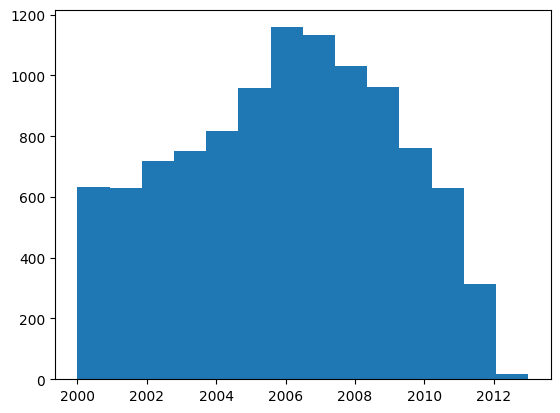

In [6]:
#Number of movies per year (2000-2016)
plt.hist(movie_metadata_filtered_date_unfiltered.Movie_release_date[movie_metadata_filtered_date_unfiltered.Movie_release_date > 1999],bins=14)

#les films après 2013 ont déjà été retiré par les précédents filtres, mieux vaut laisser comme ça ou refaire le graph au départ avec tous les films ?

/opt/jlab-env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 66582 (\N{DESERET CAPITAL LETTER JEE}) missing from current font.
  func(*args, **kwargs)
/opt/jlab-env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 66610 (\N{DESERET SMALL LETTER SHORT O}) missing from current font.
  func(*args, **kwargs)
/opt/jlab-env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 66633 (\N{DESERET SMALL LETTER ER}) missing from current font.
  func(*args, **kwargs)
/opt/jlab-env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 66635 (\N{DESERET SMALL LETTER EM}) missing from current font.
  func(*args, **kwargs)
/opt/jlab-env/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 66636 (\N{DESERET SMALL LETTER EN}) missing from current font.
  func(*args, **kwargs)
/opt/jlab-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 66582 (\N{DESERET 

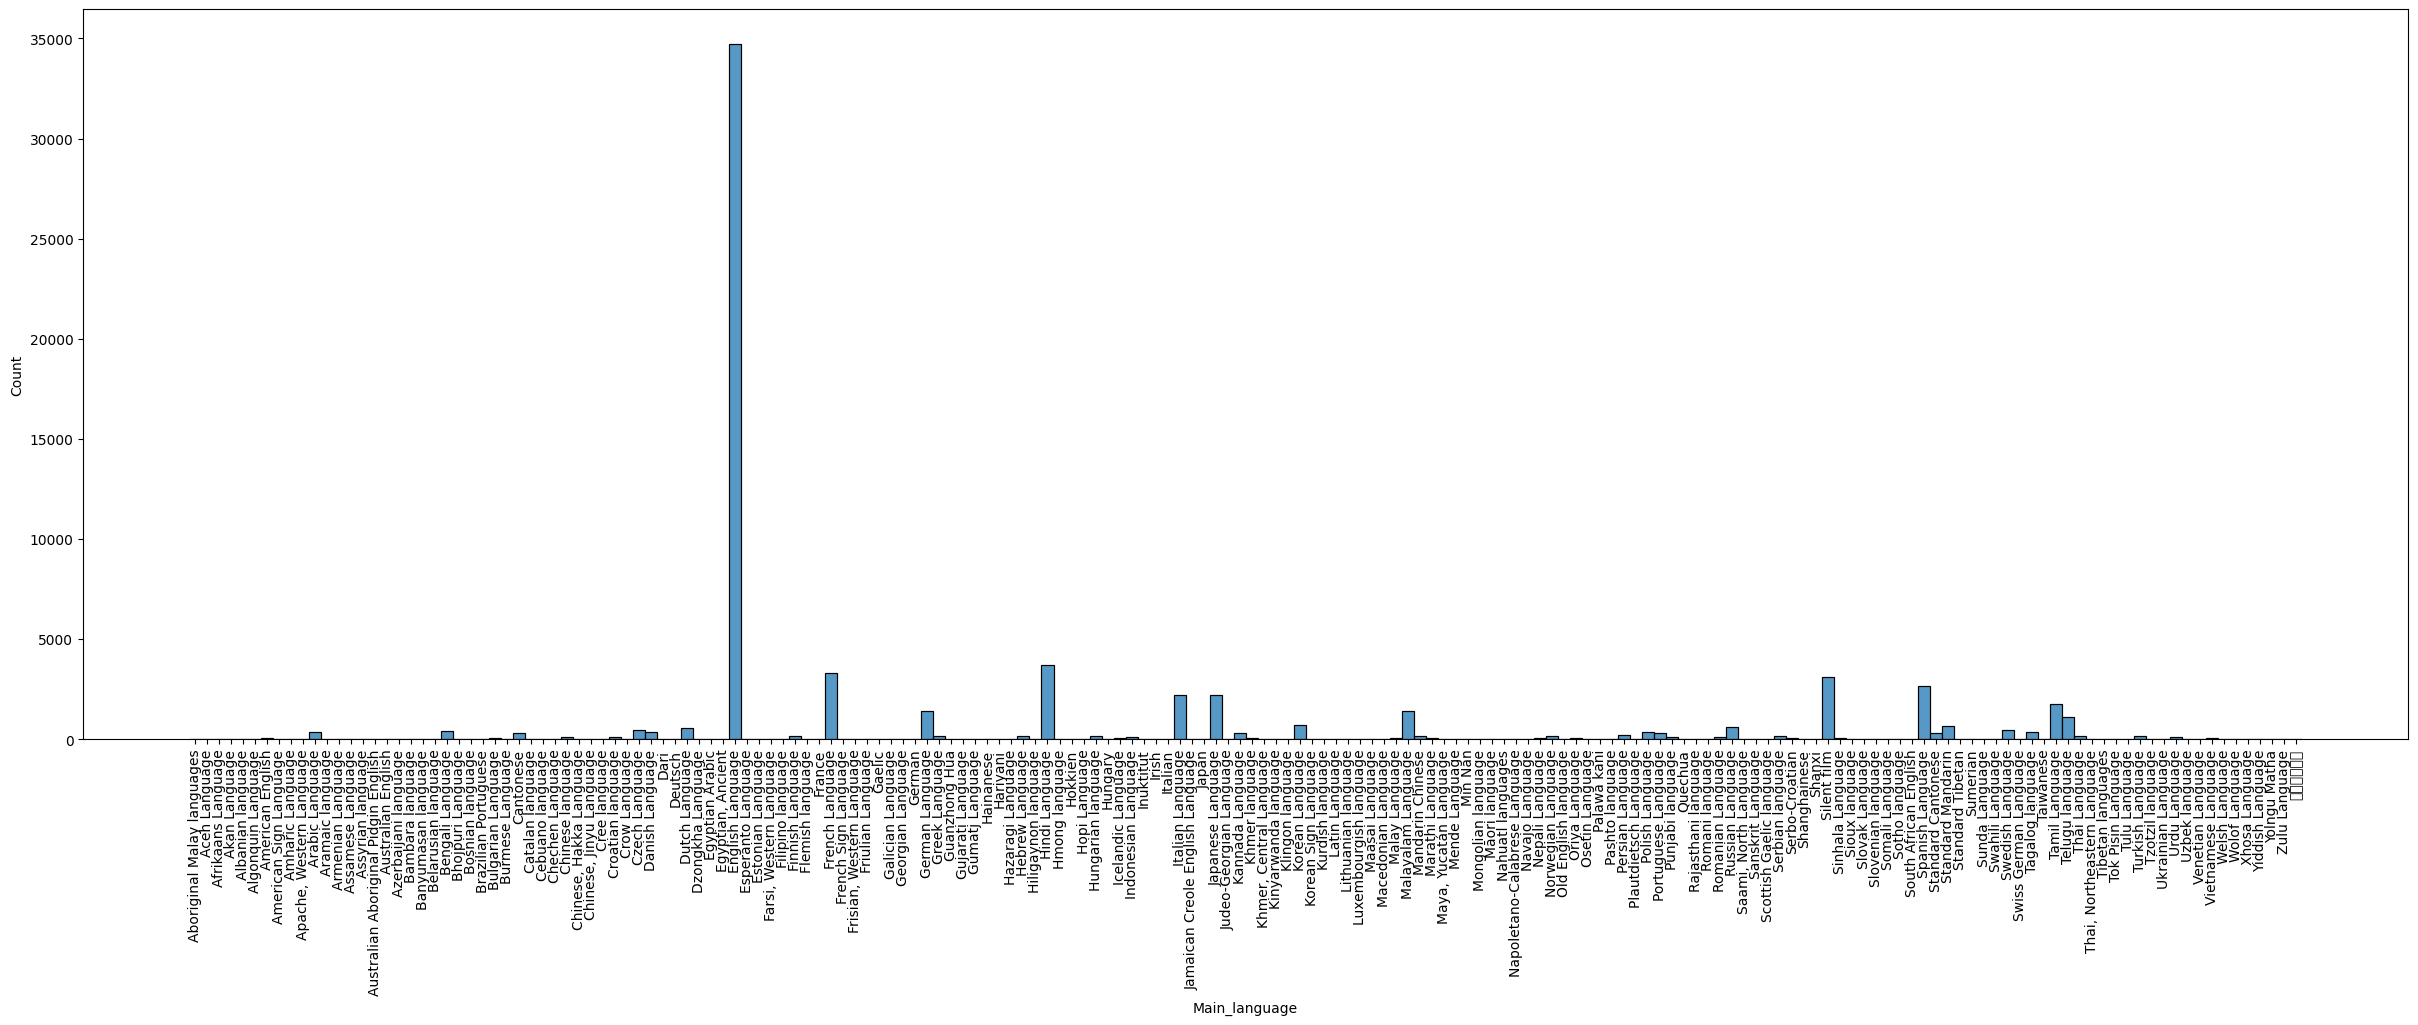

In [7]:
#Movie distribution per languages'
movie_metadata_filtered_language_unfiltered['Main_language'] = movie_metadata_filtered_language_unfiltered.Movie_languages.str[0]
movie_metadata_filtered_language_unfiltered['Main_language'] = movie_metadata_filtered_language_unfiltered.Main_language.astype('category')

plt.figure(figsize=(30,10))
plt.rc('axes', unicode_minus=False)
ax = sns.histplot(movie_metadata_filtered_language_unfiltered,x='Main_language',stat='count')
#ax.set_xticklabels(rotation=90,labels = movie_metadata_filtered_language_unfiltered['Main_language'].cat.categories)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.gcf().subplots_adjust(bottom=0.15)

#C'est dégueu et j'arrive pas à rendre ça propre...
##Les mesages d'erreur c'est parce qu'il arrive pas à afficher les caracttères non latin, j'ai essayé de m'en débarasser mais j'ai pas réussi

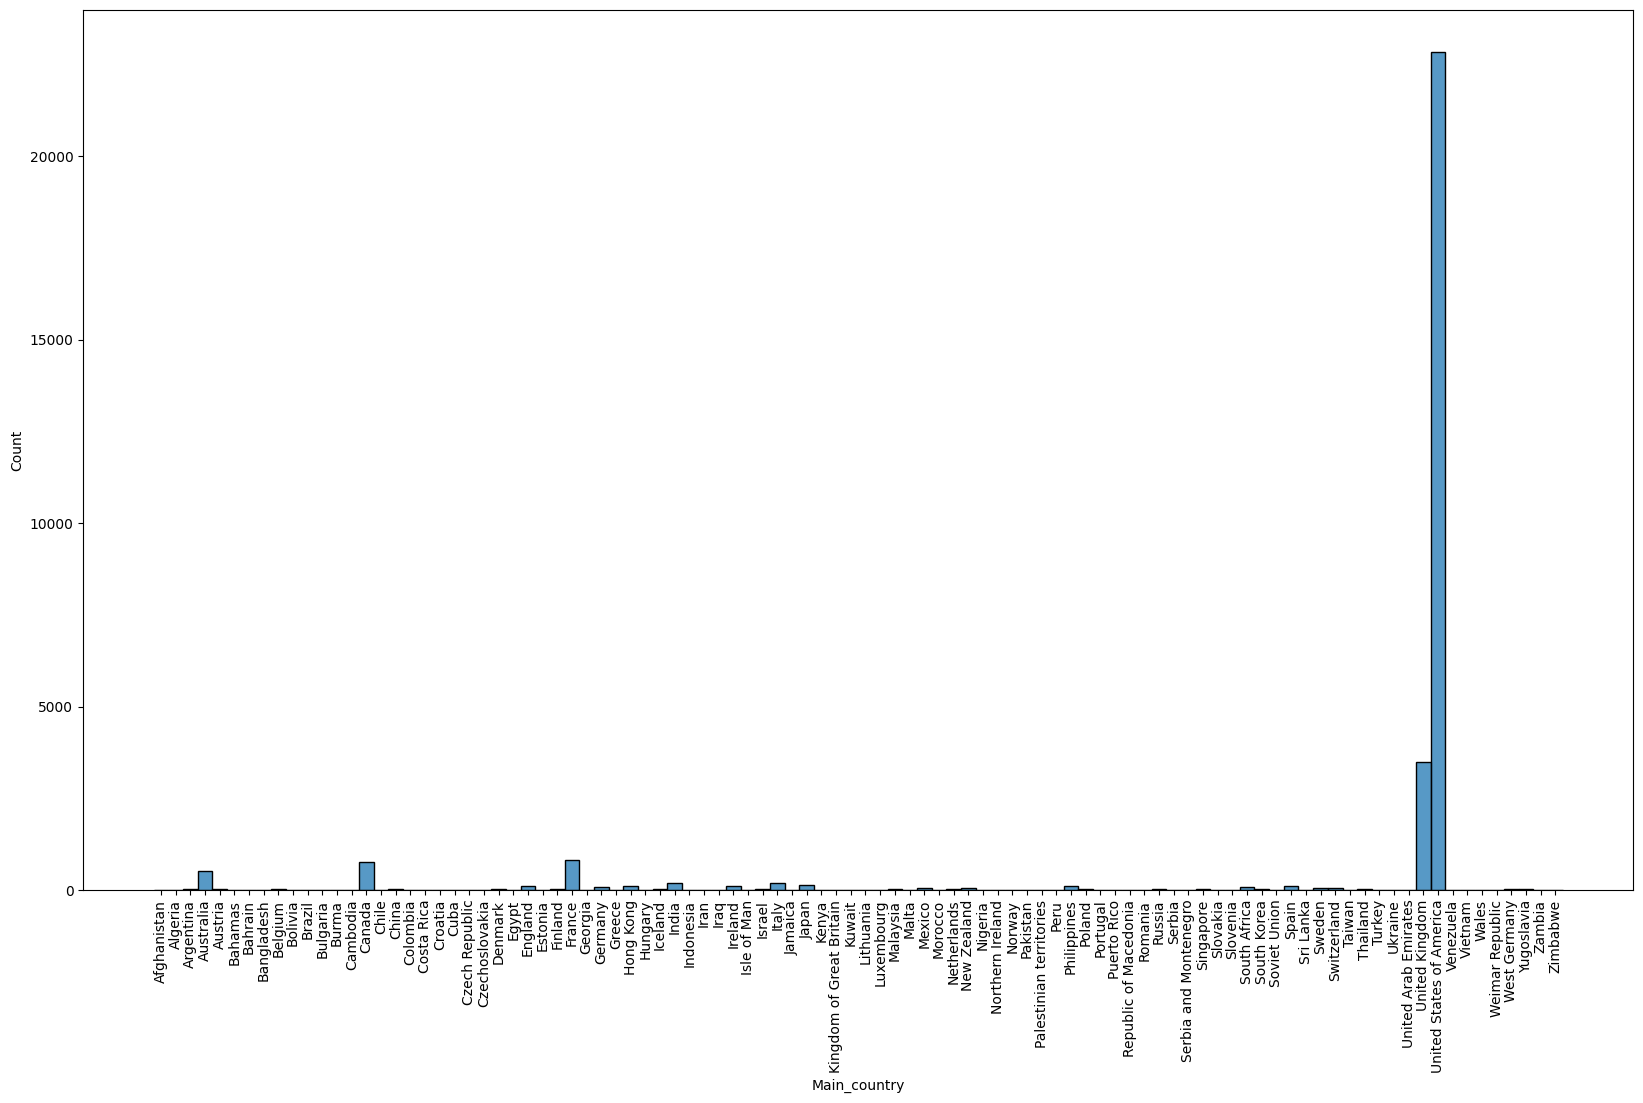

In [8]:
#Movie distribution per country of production (after filtering)
movie_metadata_filtered['Main_country'] = movie_metadata_filtered.Movie_countries.str[0]
movie_metadata_filtered['Main_country'] = movie_metadata_filtered.Main_country.astype('category')

plt.figure(figsize=(20,10))
ax = sns.histplot(movie_metadata_filtered,x='Main_country',stat='count')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.gcf().subplots_adjust(bottom=0.0)

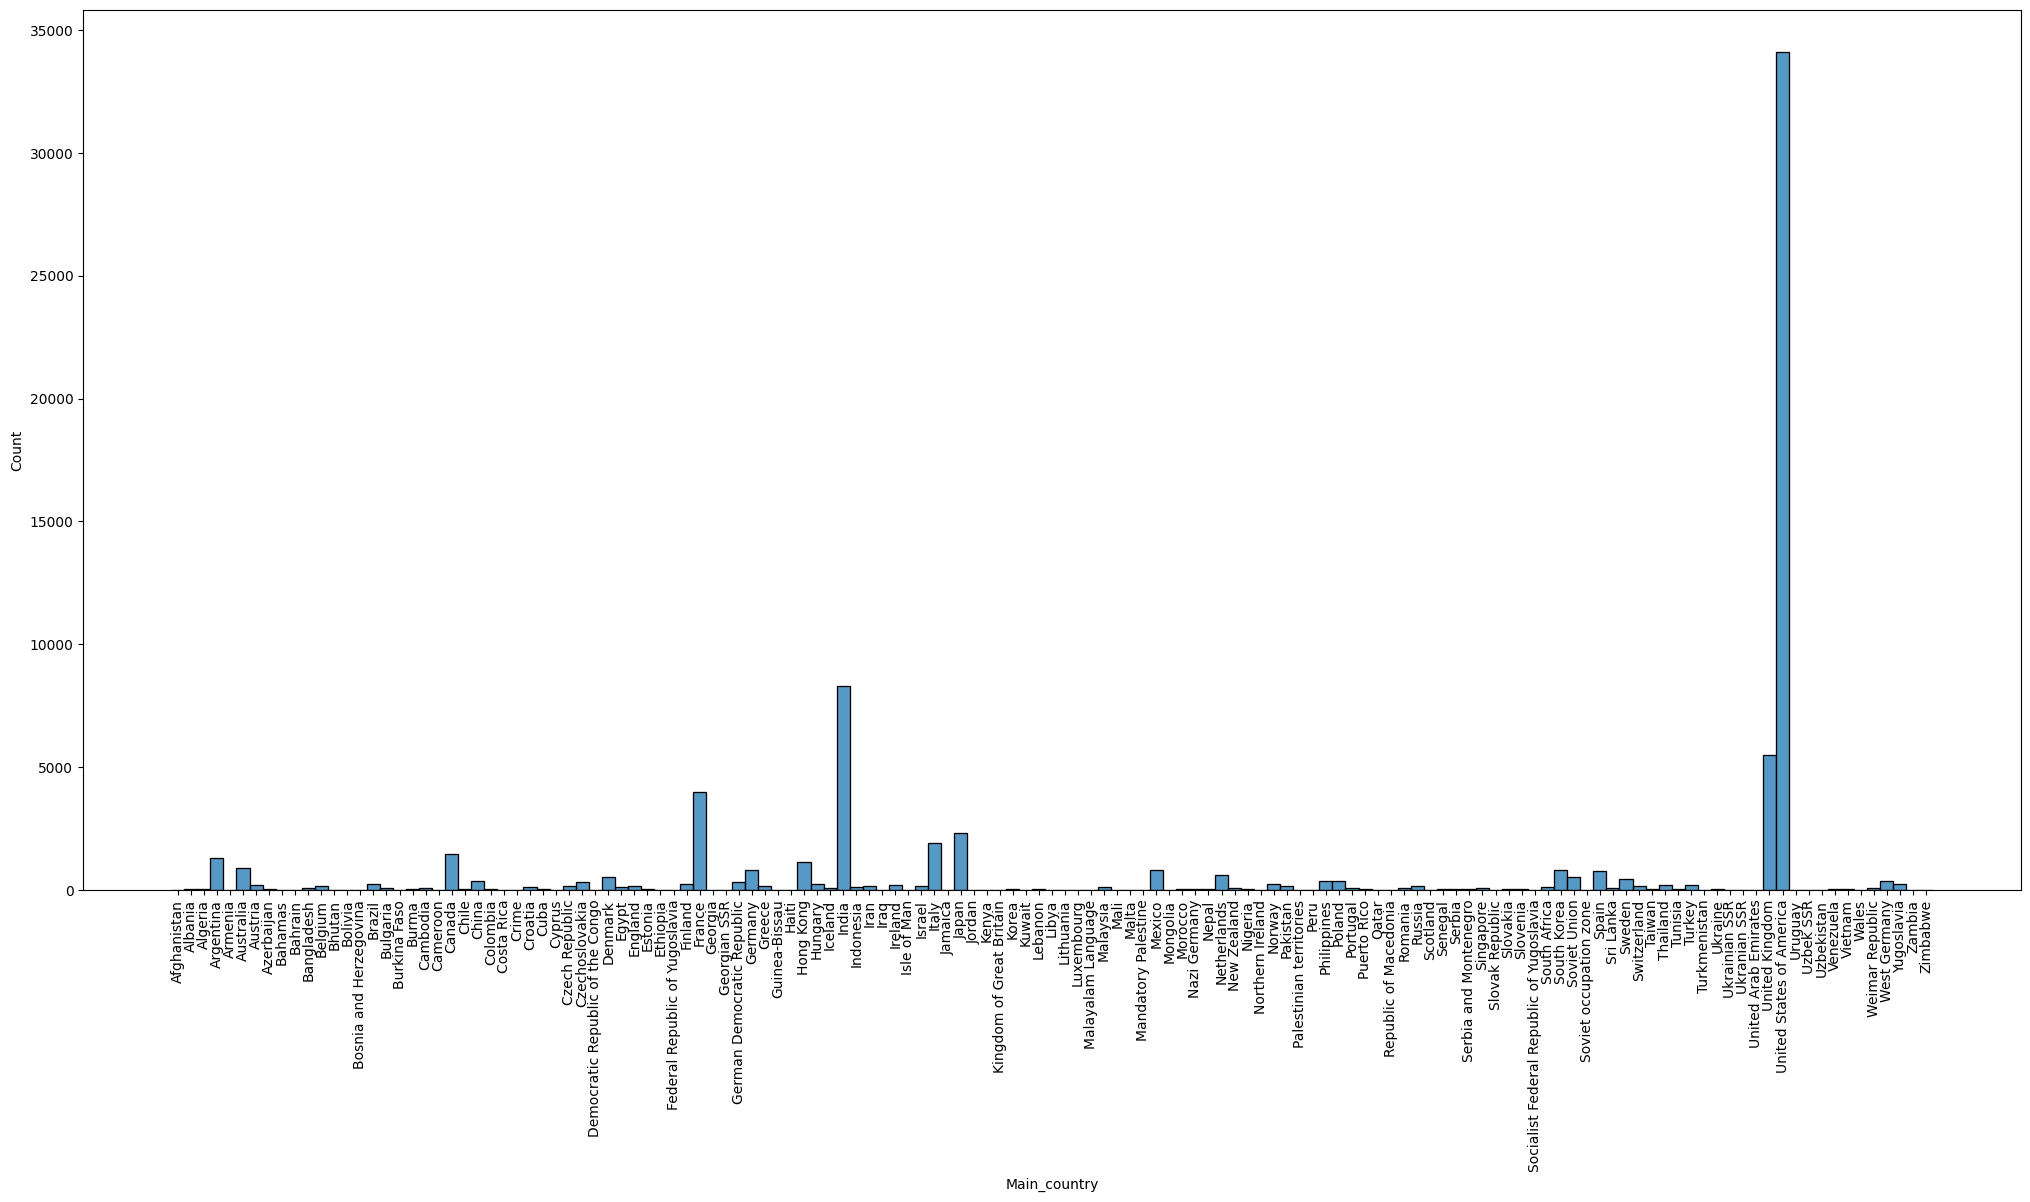

In [9]:
#Movie distribution per country of production (before filtering)
movie_metadata_filtered_language_unfiltered['Main_country'] = movie_metadata_filtered_language_unfiltered.Movie_countries.str[0]
movie_metadata_filtered_language_unfiltered['Main_country'] = movie_metadata_filtered_language_unfiltered.Main_country.astype('category')

plt.figure(figsize=(25,10))
ax = sns.histplot(movie_metadata_filtered_language_unfiltered,x='Main_country',stat='count')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.gcf().subplots_adjust(bottom=0.0)

In [10]:
movie_English_only.to_csv(path_or_buf = "Data/movies_metadata_english_only.csv", sep=',')

movie_metadata_filtered_language_unfiltered

In [11]:
# IMDB files 

ratings_imdb = pd.read_table('Data/ratings_imdb.tsv', sep="\t")
ratings_imdb.head()


movies_imdb= pd.read_table('Data/movies_imdb.tsv', sep="\t")



In [12]:
# Rotten tomatoes 

rotten_tomatoes = pd.read_table('Data/movies_rottentomatoes.csv', sep=",")
rotten_tomatoes.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [13]:
# Genre processing: give only one genre to our films, preferably the main genre (first on the list), from a "basic" dictionnary of genre


# 1st step: create a new genre dictionnary
dict_genre = {
    "Action": ["Action/adventure", "ninja movie", "epic", "auto racing", "martial arts film","Combat Films", "race movie", "samurai cinema", "Super hero", "superhero movie", "superhero"],
    "Adventure": ["Adventure", "travel"],
    "Art": ["Concert film", "Film-Opera", "Operetta", "Punk rock", "Rockumentary", "Space opera", "Singing cowboy", "Hip hop movies", "Breakdance", "Dance", "musical", "& Literature", "Literature", "Music"],
    "Comedy": ["Humour", "Tragicomedy", "Ealing Comedies", "Comdedy", "Adventure Comedy", "Commedy of manners", "Workplace comedy", "comedy-drama", "Buddy Picture", "Buddy cop", "Parody"], 
    "Documentary": ["Political Documetary", "Docudrama", "Historical Documentaries", "Rockumentary", "media studies", "media satire", "Political cinema", "Political Documentary"],
    "Drama": ["Melodrama", "Tragedy", "Tragicomedy", "Docudrama", "Family drama", "Comedy-drama", 'illnesses & disabilities'], 
    "Family": ["Family Film", "Animation", "Animated cartoon", "Children's film", "children's", "children's entertainment", "children's fantasy", "children's/family", "For children"], 
    "Fiction": ["fairy tail", "fictional film", "medical fiction", "mythological fantasy", "sci fi pictures", 'sci fi pictures original films', "sword and sorcery films", "sword and sandal", "time travel", "supernatural", "Alien invasion","Alien Film", "Zombie film", "Z-movie", "z movie", "Zombie"],
    "Historical": ["history", "Biographical", "British History", "British Empire Film", "British new wave", "Historical Epic", "Cold War", "Historical Documentaries", "Biography", "Biopic [feature]", "The Netherlands in World War II", "Gulf War", "movies about gladiators"],
    "Horror": ["Natural Horror film", "Sci-fi Horror", "road-horror", "Creature Movie", "Monster Movie", "Creature"],
    "Porn": ["Pornographic movie", "Pornography", "Softcore Porn", "Adult", "Sexploitation", "Erotica", "homoeroticism", "erotic thriller", "Hardcore pornography", "Homoeroticism"], 
    "Romance": ["Romance film", "romantic fantasy"],
    "Sport": ["baseball", "boxing", "sports"],
    "Thriller": [ "film à clef", "mystery", "suspense", 'crime', 'crime fiction', 'crime thriller', "master criminal films", "detective", "Master Criminal Films", "Heist", "Gangster Film"],
    "Western": ["Singing cowboy", "Westerns", "B-Western", "Epic Western", "Spaghetti Western"],
    "World cinema": ["Chinese Movies", "Japanese Movies", "Latino", "americana", "bengali cinema", "filipino movies", "Anime", "Indie"],
    "War film": ["war", "War effort", "anti-war", "anti-war film", "nuclear warfare", "foreign legion"],

}

In [14]:
# 2nd step: Revert the current dictionnary, easier to manipulate  À GARDER?

dict_genre_revert = {}
for key, value in dict_genre.items():
    key = key.lower() #passage en minuscule
    for v in value:
        v = v.lower()
        dict_genre_revert[v] = key
    dict_genre_revert[key] = key

In [15]:
#inspiration:  
def get_genre(set_original_genres):
    set_new_genres = set()
    for g in set_original_genres:
        g = g.lower()
        temp = True
        for s_g in g.split(" "): 
            if s_g in dict_genre_revert.keys():
                set_new_genres.add(dict_genre_revert[s_g])
                temp = False
        if temp:
            if g in dict_genre_revert.keys():
                set_new_genres.add(dict_genre_revert[g])
    return set_new_genres

In [16]:
# 3rd step:-regarder le 1er genre de la liste original, si dans clef du dict reverse, attribuer le nouveau genre correspondant
#          -si 1er genre pas dans clef, passer au 2ème genre de la liste (et faire la même chose)
#          -si aucun genre ne correspond, print la ligne

movie_EF_main_genre = movie_English_first.copy(deep=True)

movie_EF_main_genre['Movie_main_genre']=0



In [17]:
for i in movie_EF_main_genre.index:
    N=len(movie_EF_main_genre['Movie_genres'][i])
    k=0
    while k < N:
        genre = movie_EF_main_genre['Movie_genres'][i][k].lower()
        if genre in dict_genre_revert.keys():
            movie_EF_main_genre['Movie_main_genre'][i]= dict_genre_revert.get(genre)
            k=N+1
        else:
            k+=1
    if k==N:
       movie_EF_main_genre['Movie_main_genre'][i]= "ALED"

movie_EF_main_genre[movie_EF_main_genre['Movie_main_genre']=="ALED"]

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_main_genre
113,28301986,/m/0cnxjzx,Dig That Uranium,1956,NaN,61.0,[English Language],[United States of America],[Comedy film],ALED
116,3740032,/m/09yd9c,Desperate,1947,NaN,73.0,[English Language],[United States of America],[Film noir],ALED
653,12632216,/m/02wywht,The Two Worlds of Jenny Logan,1979,NaN,94.0,[English Language],[United States of America],[Romantic drama],ALED
657,33096336,/m/0h66h0p,"Jeff, Who Lives at Home",2011,4269426.0,83.0,[English Language],[United States of America],[Comedy film],ALED
692,29119625,/m/0dlmyyq,Canaries Sometimes Sing,1930,NaN,80.0,[English Language],[United Kingdom],[Comedy film],ALED
...,...,...,...,...,...,...,...,...,...,...
81083,6214470,/m/0fx586,Arcanum,2006,NaN,80.0,[English Language],[Canada],[Science Fiction],ALED
81348,20887118,/m/05b32x8,Battlestar Galactica: The Plan,2009,NaN,112.0,[English Language],[United States of America],"[Science Fiction, Sci-Fi Adventure]",ALED
81563,25655938,/m/09v7p4g,I Was a Mail Order Bride,1982,NaN,92.0,[English Language],[United States of America],[Romantic comedy],ALED
81583,35028178,/m/0j62vp8,Fast Charlie... the Moonbeam Rider,1979,444334.0,98.0,[English Language],[United States of America],[Comedy film],ALED


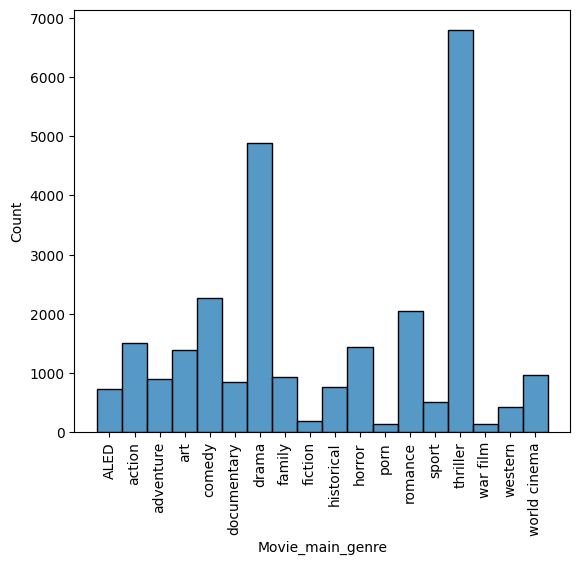

In [18]:
movie_EF_main_genre['Movie_main_genre'] = movie_EF_main_genre.Movie_main_genre.astype('category')

ax = sns.histplot(movie_EF_main_genre,x='Movie_main_genre',stat='count')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.gcf().subplots_adjust(bottom=0)


# preprocess character metadata before to merge it with movies



In [19]:
# Ajouter les noms des personnages principaux au movie.metadata
movie_English_only_copy = movie_English_only.copy(deep= True)
character_metadata_copy = character_metadata.copy(deep= True)

character_metadata_copy.dropna(subset=['Character_name'], inplace=True)
#il reste encore des NaN !!!!

movie_character = movie_English_only_copy.merge(character_metadata_copy, how='inner',left_on='Wikipedia_movie_ID', right_on='Wikipedia_movie_ID')

movie_character = movie_character[['Wikipedia_movie_ID', 'Movie_name', 'Movie_release_date_x',  'Movie_box_office_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries', 'Movie_genres', 'Character_name', 'Freebase_character_ID']]
# je sais pas pourquoi mais il veut pas mettre le wikipedia movie ID et la release date

grouped_movie_character = movie_character.groupby('Wikipedia_movie_ID').agg({
    'Movie_name': 'first',  
    'Movie_box_office_revenue': 'first', 
    'Movie_runtime': 'first', 
    'Movie_languages': 'first', 
    'Movie_countries': 'first',  
    'Movie_genres': 'first',  
    'Character_name': lambda x: ', '.join(x.dropna()),  
    'Freebase_character_ID':  lambda x: ', '.join(x.dropna())
}).reset_index()
grouped_movie_character.sample(5).head()

,Wikipedia_movie_ID,Movie_name,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Freebase_character_ID
8262,8406407,Beautiful People,NaN,117.0,[English Language],[United Kingdom],"[Black comedy, War film, Drama, Indie, Comedy]","Dr. Mouldy, Nora Thornton, Edward Thornton, Ge...","/m/0bp7rwk, /m/0bp7rts, /m/0bp7rsw, /m/0bp7rw6..."
13177,23242671,Betrayal,NaN,90.0,[English Language],[United States of America],"[Thriller, Gangster Film, Road movie, Action/A...","Emily Shaw, Det. Mark Winston","/m/0h1pz7h, /m/0h2pny_"
3178,1992647,Driving Lessons,NaN,98.0,[English Language],[United Kingdom],"[Comedy-drama, Coming of age, Drama, Comedy, I...","Ben Marshall, Laura Marshall, Peter, Sarah, Ro...","/m/0gy2111, /m/0gzt9d_, /m/0gzt9dr, /m/0gyfg8j..."
3754,2375811,Jason Goes To Hell: The Final Friday,15935068.0,89.0,[English Language],[United States of America],"[Cult, Horror, Slasher, Teen]",Diana Kimble,/m/0h342f5
2223,1275551,Cheech & Chong's Next Movie,41675194.0,95.0,[English Language],[United States of America],"[Cult, Comedy]","Cheech, Chong, Actress, Chick Hazard - Private...","/m/0h323d1, /m/0h2x98c, /m/0h15wk9, /m/0h284d8"


In [20]:
# check if one of the character's name is present in the movie title

movie_character['Character_in_title'] = movie_character.apply(lambda row: str(row['Character_name']).lower() in str(row['Movie_name']).lower(), axis=1)
movie_with_character_in_title = movie_character['Character_in_title'].sum()

print(f"Fraction of movie titles containing character name: {movie_with_character_in_title / len(grouped_movie_character):.2%}")
print(movie_character.loc[movie_character['Character_in_title'] == 1, ['Movie_name', 'Character_name']])

Fraction of movie titles containing character name: 8.25%
                                    Movie_name   Character_name
26                                     Henry V          Henry V
35                                Mary Poppins     Mary Poppins
188                ChromeSkull: Laid to Rest 2      ChromeSkull
255                     Good Morning Miss Dove        Miss Dove
374                                  RoboCop 3          RoboCop
...                                        ...              ...
98329                             Stingray Sam     Stingray Sam
98662                                    Emile            Emile
98715                            Grandma's Boy    Grandma's Boy
99119  Sherlock Holmes and the Voice of Terror  Voice of Terror
99128  Sherlock Holmes and the Voice of Terror  Sherlock Holmes

[1305 rows x 2 columns]


In [21]:
# certains noms de personnages ne sont aps vraiment des prénoms, est-ce qu'il faudra faire de la NLP?
